In [52]:
import os
import andes
import numpy as np
import pandas as pd
import pandapower as pp
import matplotlib.pyplot as plt
import scipy.stats as stat

from andes.interop.pandapower import to_pandapower, runopp_map
from andes.interop.pandapower import add_gencost, build_group_table
andes.config_logger(stream_level=20)
from math import ceil, floor

# virtual inertia scheduling class
from pdpower import make_link_table
from visopf import vis2_tds, loadnn


In [53]:
# adnes, pandapower version
print(andes.__version__)
print(pp.__version__)

1.7.0.post50.dev0+g0423427c
2.8.0


# Import data

## andes attribute

In [54]:
# ss0 is used for PP conversion
dir_path = os.path.abspath('..')
case_path = '/VIS_opf/ieee39_vis.xlsx'
case = dir_path + case_path
ssa = andes.load(case,
                 setup=True,
                 no_output=True,
                 default_config=False)

# Set output mode as 'manual'
ssa.TDS.config.save_mode = 'manual'

# set PQ constant load
ssa.PQ.config.p2p = 1
ssa.PQ.config.q2q = 1
ssa.PQ.config.p2z = 0
ssa.PQ.config.q2z = 0
ssa.PQ.pq2z = 0

# Turn on 'numba' to accelerate TDS.
ssa.config.numba

Working directory: "/Users/buxinshe/Documents/git-repo/andes/bshe/VIS_opf"
> Loaded config from file "/Users/buxinshe/.andes/andes.rc"
> Reloaded generated Python code of module "pycode".
Parsing input file "/Users/buxinshe/Documents/git-repo/andes/bshe/VIS_opf/ieee39_vis.xlsx"...
Input file parsed in 0.2500 seconds.
ACEc <1> added BusFreq <BusFreq_11> linked to bus <1>
System internal structure set up in 0.0211 seconds.


0

## load profile

In [55]:
# --- read load from ssa ---
ptotal = ssa.PQ.as_df()['p0'].sum()
print('ANDES total load is:',ptotal.round(4),'p.u.')

# --- scale load curve ---
ddata_path = '/VIS_opf/dsyn.csv'
ddata = dir_path + ddata_path
d_syn = pd.read_csv(ddata)

caseH = 10
# the coefficient can be adjusted to fit the case
if caseH == 10: # load prfile at 10am
    d_syn['sload'] = 1*(d_syn['ha10'] - d_syn['ha10'].min()) / d_syn['ha10'].min() + 1
if caseH == 18: # load prfile at 6pm
    d_syn['sload'] = 2*(d_syn['ha18'] - d_syn['ha18'].min()) / d_syn['ha18'].min() + 1

# smooth
d_syn['sload'] = d_syn['sload'].rolling(20).mean()
    
# calculate expected load
step = 300
d_exp = d_syn.groupby(d_syn.index // step).mean().copy()
d_exp['time'] = range(0, 3600, 300)

# align starting point of load with starting point of dispatch results
d_syn['sload'][0] = d_exp['sload'].iloc[0]
d_syn['sload'][1:100] = None
d_syn['sload'] = d_syn['sload'].interpolate(method='polynomial', order=3)

ystep = list(d_exp['sload'])
ystep.insert(0, d_exp['sload'].iloc[0])

ANDES total load is: 58.564 p.u.


In [56]:
d_syn # load profile with TDS inverval (1s)

,time,h10,h18,ha10,ha18,sload
0,0,4978.800000,7459.500000,5162.454000,7441.173000,1.055503
1,1,4978.758667,7459.455333,5160.978067,7440.724133,1.055374
2,2,4978.717333,7459.410667,5159.502133,7440.275267,1.055254
3,3,4978.676000,7459.366000,5158.026200,7439.826400,1.055142
4,4,4978.634667,7459.321333,5156.550267,7439.377533,1.055039
...,...,...,...,...,...,...
3595,3595,5236.523333,7745.296667,5197.508333,7671.689667,1.076477
3596,3596,5236.958667,7745.397333,5196.173067,7671.962933,1.076391
3597,3597,5237.394000,7745.498000,5194.837800,7672.236200,1.076284
3598,3598,5237.829333,7745.598667,5193.502533,7672.509467,1.076156


In [57]:
ystep # load profile with dispatch interval (300s, 5mins)

[1.0555031709041927,
 1.0555031709041927,
 1.016876029042204,
 1.039358429662416,
 1.0476457548742757,
 1.0650078929453062,
 1.0679651172652076,
 1.050017343129504,
 1.0400943896685766,
 1.0559333102231305,
 1.07152626044408,
 1.0632047614278262,
 1.0590590776327036]

Text(0.5, 0, 'Time [s]')

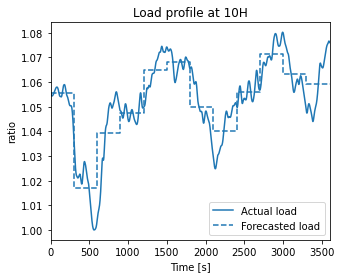

In [58]:
# --- plot load curve ---
fig_load, ax_load = plt.subplots(figsize=(5, 4))

# tds load profile
ax_load.plot(
                d_syn['time'], 
                d_syn['sload'], 
                color='tab:blue', 
                linestyle='-'
            )
# ED load profile
ax_load.step(
                range(0,3900,300), 
                ystep, 
                color='tab:blue', 
                linestyle='--'
            )
            
ax_load.set_xlim([0, 3600])
ax_load.legend(['Actual load', 'Forecasted load'])
ax_load.set_title(f'Load profile at {caseH}H')
ax_load.set_ylabel('ratio')
ax_load.set_xlabel('Time [s]')

## setup pandapower and vis gorubipy instance

### vis gurobipy instance

In [59]:
# get neural network data
nn_path = '/VIS_opf/NN_train'
nn, norm = loadnn(nn_path)

# ini visopf attribute
ssvis = vis2_tds(norm=norm, nn=nn, dpe=0, rocof_lim=0.033, nadir_lim=0.01)

# set vsg gen
vsg_ieee39 = ['PV_1', 'PV_6', 'PV_8', 'PV_9']

# load from andes
ssvis.from_andes(ssa, vsg_ieee39, Sbase=1000)

# add gen cost:
# Note: if two gens have the same cost, optimization results of
#       pandapower and gurobipy may be different.
linearcost = [
                0.5,   # PV_1 vsg
                1, 
                1.5,
                0.8, 
                0.8, 
                1,     # PV_6 vsg
                1, 
                0.6,   # PV_8 vsg
                0.5,   # PV_9 vsg 
                1.5    # slack
            ]

# set up cost
ssvis.cost['c1'] = linearcost
ssvis.update_dict()

ssvis.cost

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0041 seconds.
0: |F(x)| = 7.561249598
1: |F(x)| = 2.916162515
2: |F(x)| = 0.1315330771
3: |F(x)| = 0.0003398595952
4: |F(x)| = 4.189813829e-09
Converged in 5 iterations in 0.0080 seconds.
Power flow results are consistent. Conversion is successful.
GSF is consistent.
Note: Control (dynamic) parameters are renormalized based on case Sbase rather then to andes base


,idx,c2,c1,c0,cru,crd
0,PV_1,0,0.5,0,0,0
1,PV_2,0,1.0,0,0,0
2,PV_3,0,1.5,0,0,0
3,PV_4,0,0.8,0,0,0
4,PV_5,0,0.8,0,0,0
5,PV_6,0,1.0,0,0,0
6,PV_7,0,1.0,0,0,0
7,PV_8,0,0.6,0,0,0
8,PV_9,0,0.5,0,0,0
9,Slack_10,0,1.5,0,0,0


### pandapower

In [60]:
# convert andes to a pandapower instance
ssp = to_pandapower(ssa)

# set up pandapower gen cost
gen_cost = np.array([[2., 0., 0., 3., 0., 0., 0.]] * ssp.gen.shape[0])
gen_cost[:, 5] = linearcost  # c1

add_gencost(ssp, gen_cost)

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0032 seconds.
0: |F(x)| = 7.561249598
1: |F(x)| = 2.916162515
2: |F(x)| = 0.1315330771
3: |F(x)| = 0.0003398595952
4: |F(x)| = 4.189813829e-09
Converged in 5 iterations in 0.0048 seconds.
Power flow results are consistent. Conversion is successful.


True

In [61]:
# run pandapower dc opf
pp.rundcopp(ssp)
ppres = ssp.res_gen.copy()

# run gorubi dc opf
ssdc = ssvis.to_dcopf()
gb_res = ssdc.get_res()

ppres['p_mw(gurobi)'] = ssp.sn_mva * gb_res['pg'].values

print(f"pp cost={ssp.res_cost / 100}, gb cost={ssdc.mdl.getObjective().getValue()}")

ppres

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Successfully build DCOPF model.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 69 rows, 10 columns and 546 nonzeros
Model fingerprint: 0x9a0f9299
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [5e-01, 2e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [6e+01, 2e+03]
Presolve removed 68 rows and 5 columns
Presolve time: 0.00s
Presolved: 1 rows, 5 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.5132000e+01   1.253200e+01   0.000000e+00      0s
       1    4.2464000e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.246400000e+01


Successfully solve DCOPF.


pp cost=46.043095745989376, gb cost=42.464


,p_mw,q_mvar,va_degree,vm_pu,p_mw(gurobi)
0,1344.180850,95.188635,24.875925,1.0,1500.0
1,212.219198,311.907993,-2.810178,1.0,756.4
2,100.000000,149.807913,-1.721699,1.0,100.0
3,700.000000,131.573046,22.240770,1.0,700.0
4,700.000000,146.758289,23.598772,1.0,700.0
5,799.999975,228.233225,24.980648,1.0,0.0
6,699.999975,63.490085,29.057410,1.0,100.0
7,0.000002,-28.822379,9.608975,1.0,700.0
8,1000.000000,126.624527,29.272266,1.0,1000.0
9,300.000000,-27.788743,0.000000,1.0,300.0


## Link table between pandapower and andes

In [62]:
# --- link pandapower output to andes key ---
ssa_key = make_link_table(ssa)

# make index table to change pandapower and andes setting point
# pandapwoer uses dataframe index, i.g. 0, 1, 2 ....
# andes uses idx to call variable

# --- add controllable in the link table ---
ssa_bus = ssa.Bus.as_df().reset_index().rename(columns={'uid':'bus_pp', 'idx':'bus_idx'})
ssp_gen = ssp.gen.reset_index().rename(columns={'index':'gen_pp', 'name':'stg_idx', 'controllable':'ctrl'})

ssa_key2 = pd.merge(
                        left=ssa_key,
                        right=ssp_gen[['stg_idx', 'gen_pp', 'ctrl']],
                        on='stg_idx', 
                        how='left'
                    )

# --- device idx ---
# use to set andes setting point
ssa_dg_idx = ssa_key2.dg_idx.dropna().tolist()   
ssa_syg_idx = ssa_key2.syg_idx.dropna().tolist()
ssa_gov_idx = ssa_key2.gov_idx.dropna().tolist() 
ssa_stg_idx = ssa_key2.stg_idx.dropna().tolist() # static gen
ssa_rg_idx = ssa_key2.rg_idx.dropna().tolist()   # renewable gen: vsg

# --- online and controllable device idx ---
ctrl_cond = ssa_key2.ctrl & ssa_key2.stg_u.astype(bool)

ssa_dg_idx_ctrl = ssa_key2.dg_idx[ctrl_cond].dropna().tolist()
ssa_syg_idx_ctrl = ssa_key2.syg_idx[ctrl_cond].dropna().tolist()
ssa_gov_idx_ctrl = ssa_key2.gov_idx[ctrl_cond].dropna().tolist()
ssa_stg_idx_ctrl = ssa_key2.stg_idx[ctrl_cond].dropna().tolist()

# fill NaN with False
ssa_key2.fillna(value=False, inplace=True)

ssa_key2

,stg_name,stg_u,stg_idx,bus_idx,dg_idx,rg_idx,syg_idx,exc_idx,gov_idx,bus_name,gammap,gammaq,gen_pp,ctrl
0,PV_2,1.0,PV_2,31,False,False,GENROU_2,IEEEX1_2,TGOV1_2,GEN31,1.0,1.0,1,True
1,PV_3,1.0,PV_3,32,False,False,GENROU_3,IEEEX1_3,TGOV1_3,GEN32,1.0,1.0,2,True
2,PV_4,1.0,PV_4,33,False,False,GENROU_4,IEEEX1_4,TGOV1_4,GEN33,1.0,1.0,3,True
3,PV_5,1.0,PV_5,34,False,False,GENROU_5,IEEEX1_5,TGOV1_5,GEN34,1.0,1.0,4,True
4,PV_7,1.0,PV_7,36,False,False,GENROU_7,IEEEX1_7,TGOV1_7,GEN36,1.0,1.0,6,True
5,Slack_10,1.0,Slack_10,39,False,False,GENROU_10,IEEEX1_10,TGOV1_10,GEN39,1.0,1.0,9,True
6,PV_1,1.0,PV_1,30,False,VSG_1,False,False,False,GEN30,1.0,1.0,0,True
7,PV_6,1.0,PV_6,35,False,VSG_2,False,False,False,GEN35,1.0,1.0,5,True
8,PV_8,1.0,PV_8,37,False,VSG_3,False,False,False,GEN37,1.0,1.0,7,True
9,PV_9,1.0,PV_9,38,False,VSG_4,False,False,False,GEN38,1.0,1.0,8,True


In [63]:
len(ssa_rg_idx)

4

## Auxliary function

In [64]:
def disturbance(d_syn, idx_ed, intv_ed):
    """
        get disturbance
        
        return:
        ----------
        - load_exp: load forecasted value
        - dpe: delta load change
        - dvsg: vsg gen capacity change
    """
    idx0 = idx_ed * intv_ed # start index
    idx1 = idx0 + intv_ed   # end index

    # --- load change ---
    load = d_syn['sload'].iloc[idx0 : idx1] 
    load_exp = load.mean()

    # --- dpe ---
    if idx_ed == 0:
        dpe = 0
    else:
        load_early = d_syn['sload'].iloc[idx0 - intv_ed : idx1 - intv_ed]
        load_exp_early = load_early.mean()
        dpe = load_exp - load_exp_early

    # --- vsg gen capacity change ---
    # TODO: add vsg gen capacity change
    dvsg = [0] * len(ssa_rg_idx)

    return load_exp, dpe, dvsg

# TDS simulation

## TSD sim parameters

In [65]:
# --- TDS Constants ---
t_total = 3600  # total simulation time

# update interval
intv_ed = 300   # RTED
intv_agc = 4    # AGC
intv_pq = 1     # PQ load
intv_step = 100 # step change to smooth the setpoitns

# number of intervals
n_ed = int(t_total/intv_ed)
n_agc = int(intv_ed/intv_agc)
n_pq = int(intv_agc/intv_pq)
n_step = floor(intv_step/intv_agc)

# --- TDS vars ---
# AGC table
agc_table = ssp.gen[['name']].rename(columns={'name':'stg_idx'})
agc_table['paux'] = 0
agc_res = agc_table[['stg_idx']].copy()

# ACE vars for PI controller
ACE_integral = 0
ACE_raw = 0
Kp = 0.2 # 0.05
Ki = 0.1
ace_res = pd.DataFrame()

# initial load value
ssa_p0 = ssa.PQ.p0.v.copy()
ssa_q0 = ssa.PQ.q0.v.copy()
ssa_pq_idx = ssa.PQ.idx.v
ssa_p0_sum = ssa_p0.sum()

In [66]:
agc_table

,stg_idx,paux
0,PV_1,0
1,PV_2,0
2,PV_3,0
3,PV_4,0
4,PV_5,0
5,PV_6,0
6,PV_7,0
7,PV_8,0
8,PV_9,0
9,Slack_10,0


In [67]:
ssp_gen

,gen_pp,stg_idx,bus,p_mw,vm_pu,sn_mva,min_q_mvar,max_q_mvar,scaling,slack,in_service,slack_weight,type,ctrl,min_p_mw,max_p_mw,power_station_trafo
0,0,PV_1,29,436.086385,1.035534,100.0,-58.084,183.8160,1.0,False,True,0.0,None,True,0.0,1500.0,NaN
1,1,PV_2,30,645.999998,1.013246,100.0,-122.665,515.7648,1.0,False,True,0.0,None,True,150.0,900.0,NaN
2,2,PV_3,31,724.999998,1.020528,100.0,-180.218,536.0664,1.0,False,True,0.0,None,True,100.0,800.0,NaN
3,3,PV_4,32,651.999998,1.013430,100.0,-213.780,657.8496,1.0,False,True,0.0,None,True,100.0,700.0,NaN
4,4,PV_5,33,520.000000,1.019109,100.0,-188.028,733.7940,1.0,False,True,0.0,None,True,100.0,700.0,NaN
5,5,PV_6,34,690.000000,1.060000,100.0,-234.972,712.5456,1.0,False,True,0.0,None,True,0.0,800.0,NaN
6,6,PV_7,35,590.000000,1.060000,100.0,-249.132,682.0464,1.0,False,True,0.0,None,True,100.0,700.0,NaN
7,7,PV_8,36,330.000000,1.013996,100.0,-216.122,532.1616,1.0,False,True,0.0,None,True,0.0,700.0,NaN
8,8,PV_9,37,780.000000,1.052803,100.0,-356.889,1001.7300,1.0,False,True,0.0,None,True,0.0,1000.0,NaN
9,9,Slack_10,38,574.170000,1.030000,100.0,-173.261,574.8500,1.0,True,True,0.0,None,True,300.0,1500.0,NaN


## TDS loop

In [68]:
# Reserve some capacity to avoid TDS crush
ssp.gen.max_p_mw = ssp.gen.max_p_mw

# store original generator data
ssp_gen0 = ssp.gen.copy()

t_total = 700

for time in range(t_total):  # t_total

    # ----------------------- RTED (VIS opf) interval -------------------------
    if time % intv_ed == 0:
        """
            RTED update with vis opf

            attributes:
            ----------
            - 01 get disturbance
            - 02 update visopf instance
            - 03 update pandapower instance
            - 04 update andes instance
        """
        # --- 01 get disturbance ---
        idx_ed = time // intv_ed
        load, dpe, dvsg_capacity = disturbance(d_syn, idx_ed, intv_ed)

        # --- 02 update visopf instance ---
        # load
        ssvis.load['p0'] = ssa_p0 * load # visopf load update
        # dpe
        ssvis.dpe = dpe
        # vsg gen capacity
        # TODO ... update vsg gen capacity of visopf

        ssvis.update_dict()

        # solve visopf
        visres, vsg_res, _ = ssvis.get_res() 

        # --- 03 update pandapwoer instance ---
        # load
        ssp.load.scaling = load
        # pandapower gen
        ssp_gen = pd.merge(
                            left=ssp.gen.rename(columns={'name': 'stg_idx'}),
                            right=visres.rename(columns={'gen': 'stg_idx'}),
                            on='stg_idx',
                            how='left'
                        )

        # vsg power reserve limits
        # TODO: integrate delta vsg capacity change here
        ssp_gen['vsg_up'] = ssp_gen.max_p_mw - ssp_gen.pru * ssp.sn_mva
        ssp_gen['vsg_d'] = ssp_gen.min_p_mw + ssp_gen.prd * ssp.sn_mva

        ssp.gen.max_p_mw = ssp_gen['vsg_up']
        ssp.gen.min_p_mw = ssp_gen['vsg_d']

        # run pandapower ACOPF, modify setpoints
        # store setpoints
        if time > 0:
            p0 = ssp_res['p'].values        # store setpoints
        else:
            p0 = [0] * ssa_key2.shape[0]

        # solve ACOPF
        ssp_res = runopp_map(ssp, ssa_key)  # ACOPF resutls
        ssp_res['p0'] = p0                  # last setpoints
        ssp_res.fillna(False, inplace=True) # Fill NA wil False

        # reset Generator limtis to normal limits
        # TODO: integrate delta vsg capacity change here
        ssp.gen.max_p_mw = ssp_gen0.max_p_mw
        ssp.gen.min_p_mw = ssp_gen0.min_p_mw

        # --- 04 update andes instance ---
        ssa.REGCV1.set(
                        src='M', 
                        idx= ssa.REGCV1.idx.v,
                        attr='v',
                        value= vsg_res['Mvsg']
                    )
        ssa.REGCV1.set(
                        src='D', 
                        idx= ssa.REGCV1.idx.v, 
                        attr='v',
                        value= vsg_res['Dvsg']
                    )

    # ---------------------- AGC interval -------------------------
    """
        AGC update

        attributes:
        ----------
        - 01 assign ACE signla to gen 
        - 02 smooth setpoints
    """
    ace_gain = 1

    if time % intv_agc == 0:
        idx_agc = time // intv_agc - idx_ed * n_agc
        # --- 01 allocate AGC ---

        # ACE_raw > 0: assign to expensive gen
        # ACE_raw < 0: assign to cheap gen
        if ACE_raw > 0:
            agc_idx = ['TGOV1_10', 'TGOV1_2'] # TODO: change to expensive gen
        else:
            agc_idx = ['TGOV1_4', 'TGOV1_5'] # TODO: change to cheap gen

        ssa.TurbineGov.set(
                            src='paux0',
                            idx= agc_idx,
                            attr='v',
                            value= ACE_raw/len(agc_idx) # allocate equally to each agc gen
                        )

        # --- smooth setpoints ---
        if idx_ed == 0:
            ssp_res['pref'] = ssp_res['p']
        else:
            idx_step = min((time - idx_ed * intv_ed) // intv_agc + 1, n_step)
            ssp_res['pref_step'] = ssp_res.p - ssp_res.p0
            ssp_res['pref_step'] = ssp_res.p - ssp_res.p0
            # smooth change threshold: 0.1
            # ... check ssp_res format for vsg setpoints
            large_index = ssp_res['pref_step'][abs(ssp_res['pref_step']) > 0.01].index
            ssp_res['pref_delta'] = ssp_res['pref_step']
            ssp_res['pref_delta'].iloc[large_index] = ssp_res['pref_step'].iloc[large_index] / n_step * idx_step
            ssp_res['pref'] = ssp_res.p0 + ssp_res.pref_delta

            # update SynGen setpoints
            cond_gov = ssp_res.controllable & ssp_res.gov_idx.astype(bool)
            ssa.TurbineGov.set(
                                src='pref0', 
                                idx=ssp_res.gov_idx[cond_gov].tolist(),
                                attr='v',
                                value=ssp_res.pref[cond_gov].values
                            )
            # update DG setpoints
            cond_dg = ssp_res.controllable & ssp_res.dg_idx.astype(bool)
            ssa.DG.set(
                        src='pref0', 
                        idx=ssp_res.dg_idx[cond_dg].tolist(),
                        attr='v', 
                        value=ssp_res.pref[cond_dg].values
                    )
            # update vsg setpoints
            cond_rg = ssp_res.controllable & ssp_res.rg_idx.astype(bool)
            ssa.RenGen.set(
                                src='Pref', 
                                idx=ssp_res.rg_idx[cond_rg].tolist(),
                                attr='v',
                                value=ssp_res.pref[cond_rg].values
                            )

    # ----------------------- load change interval ----------------------
    """
        load change 

        attributes:
        ----------
        - 01 update load
        - 02 run TDS
    """
    # Initially, alter StaticGen: p0 and q0, RUN power flow
    # Otherwise, alter Ppf and Qpf
    if time == 0:
        # get idx from pandapower results
        stg_opf_idx = ssp_res.stg_idx[ssp_res.controllable].tolist()
        stg_opf_val = ssp_res.p[ssp_res.controllable].tolist()
        stg_opf_v = ssp_res.vm_pu[ssp_res.controllable].tolist()

        ssa.StaticGen.set(
                            src='p0',
                            idx=stg_opf_idx,
                            attr='v',
                            value=stg_opf_val
                        )
        ssa.StaticGen.set(
                            src='v0', 
                            idx=stg_opf_idx, 
                            attr='v', 
                            value=stg_opf_v
                        )

        # initial load point set as the dispatch point
        ssa.PQ.set(
                    src='p0', 
                    idx=ssa_pq_idx, 
                    attr='v',
                    value=ssa_p0 * load
                )
        ssa.PQ.set(
                    src='q0', 
                    idx=ssa_pq_idx, 
                    attr='v',
                    value=ssa_q0 * load
                )
        ssa.PFlow.run()
    else:
        ssa.PQ.set(
                    src='Ppf', 
                    idx=ssa_pq_idx, 
                    attr='v',
                    value=ssa_p0 * d_syn['sload'].iloc[time]
                )
        ssa.PQ.set(
                    src='Qpf', 
                    idx=ssa_pq_idx, 
                    attr='v',
                    value=ssa_q0 * d_syn['sload'].iloc[time]
                )

    # ----------------------- run TDS, cal ACE ----------------------
    # run TDS
    ssa.TDS.config.tf = time
    if time == 0:
        ssa.TDS.init()
        ACE_raw = 0 # delete when run TDS ???
    ssa.TDS.run()

    # update AGC using PI Controller
    ACE_integral += ssa.ACEc.ace.v.sum()
    ACE_raw = -( Kp * ssa.ACEc.ace.v.sum() + Ki * ACE_integral )

   # ----------------------- TDS error break ----------------------
    if ssa.exit_code != 0:
        raise ValueError(f"TDS error! Exit with {ssa.exit_code}, end at {time} s.")

Successfully build var.
Successfully build obj.
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Successfully build cons.
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1040 rows, 678 columns and 11118 nonzeros
Model fingerprint: 0xb4f7834f
Variable types: 358 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [4e-06, 1e+02]
  Objective range  [5e-01, 2e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [5e-03, 2e+03]
Found heuristic solution: objective 46.8923094
Presolve removed 571 rows and 349 columns
Presolve time: 0.01s
Presolved: 469 rows, 329 columns, 5294 nonzeros
Variable types: 173 continuous, 156 integer (156 binary)

Root relaxation: objective 4.564039e+01, 260 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Dep

Msys and Dsys are normlized by devise Sbase, transform to andes Sbase when do TDS


--------------------- Results -------------------
Total Cost: 45.6404
RoCof prediction: 0 ; RoCof limit: 0.033
Nadir prediction: -0 ; Nadir limit 0.01


-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0036 seconds.
0: |F(x)| = 11.38032882
1: |F(x)| = 3.772394717
2: |F(x)| = 0.2363578096
3: |F(x)| = 0.001757819704
4: |F(x)| = 1.212768241e-07
Converged in 5 iterations in 0.0049 seconds.
GENROU (xl <= xd2) out of typical upper limit.

   idx     | values | limit
-----------+--------+------
 GENROU_2  | 0.042  | 0.036
 GENROU_3  | 0.036  | 0.003
 GENROU_4  | 0.025  | 0.001
 GENROU_5  | 0.050  | 0.001
 GENROU_7  | 0.031  | 0.002
 GENROU_10 | 0.003  | 0.000


Initialization for dynamics completed in 0.0329 seconds.
Initialization was successful.

-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-0 s.
Fixed step size: h=33.33 ms. Shrink if not converged.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=0.00 sec completed in 0.0008 seconds.

-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-1 s.
Fixed step size: h=33.33 ms. Shrink if not converged.


  0%|          | 0/100 [00:00<?, ?%/s]

Current step size is zero. Integration is not permitted.
Simulation to t=1.00 sec completed in 0.0519 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2.00 sec completed in 0.0355 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3.00 sec completed in 0.0372 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=4.00 sec completed in 0.0409 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=5.00 sec completed in 0.0390 seconds.


<Toggler Toggler_1>: GENROU.GENROU_2 status changed to 0 at t=5.0 sec.


  0%|          | 0/100 [00:00<?, ?%/s]

Time step reduced to zero. Convergence is not likely.
Simulation terminated at t=5.9189 s.
Simulation to t=6.00 sec completed in 1.1730 seconds.


ValueError: TDS error! Exit with 1, end at 6 s.